# Neoclassical Growth Model: Numeric Policy Function Iteration

This notebook solves the **discrete-time** neoclassical growth model using **Value Function Iteration (VFI)** and **Policy Function Iteration (Howard improvement)** on a state-space grid.

## Model (discrete time)

- **State**: capital $k_t$
- **Control**: consumption $c_t$ (or next-period capital $k_{t+1}$)
- **Production**: $y_t = k_t^\alpha$
- **Resource constraint**: $c_t + k_{t+1} = (1-\delta) k_t + k_t^\alpha$
- **Utility**: $u(c) = \frac{c^{1-\gamma}}{1-\gamma}$ (CRRA)
- **Bellman**: $V(k) = \max_{k'} \left\{ u\big((1-\delta)k + k^\alpha - k'\big) + \beta V(k') \right\}$

**Note on the sign of the value function:** With CRRA utility $u(c) = c^{1-\gamma}/(1-\gamma)$, when **γ > 1** (e.g. γ = 2) we have $u(c) = -1/c < 0$ for all $c > 0$. So the value function $V(k) = \sum_{t\ge 0} \beta^t u(c_t)$ is **negative** — this is correct, not a bug. If you prefer a positive scale, use **γ = 1** (log utility $u(c)=\ln c$) or **γ < 1** (e.g. γ = 0.5 gives $u(c) = 2\sqrt{c} > 0$).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

## Parameters

Same calibration as the continuous-time notebook for comparability. In discrete time we use $\beta = 1/(1+\rho)$.

In [2]:
# Model parameters (aligned with continuous-time notebook)
rho = 0.05       # Discount rate (continuous time)
beta = 1.0 / (1.0 + rho)  # Discount factor (discrete time)
alpha = 0.3      # Capital share
delta = 0.1      # Depreciation rate
gamma = 2.0      # CRRA coefficient

# State space: capital grid
k_min = 0.1
k_max = 10.0
n_k = 600        # Number of grid points (higher density for more precise solution)

print("Parameters:")
print(f"  beta = {beta:.4f}, alpha = {alpha}, delta = {delta}, gamma = {gamma}")
print(f"  k in [{k_min}, {k_max}], n_k = {n_k}")

Parameters:
  beta = 0.9524, alpha = 0.3, delta = 0.1, gamma = 2.0
  k in [0.1, 10.0], n_k = 600


## State grid and helper functions

In [3]:
# Capital grid (log-spacing often works better for growth models)
k_grid = np.linspace(k_min, k_max, n_k)

def production(k):
    """Production: y = k^alpha."""
    return np.maximum(k ** alpha, 1e-12)

def utility(c, gam=gamma):
    """CRRA utility. u(c) = c^(1-gam)/(1-gam) or log(c) if gam==1."""
    c = np.maximum(c, 1e-12)
    if np.isclose(gam, 1.0):
        return np.log(c)
    return (c ** (1 - gam)) / (1 - gam)

def feasible_next_k(k):
    """Feasible next-period capital: k' in [k_min, (1-delta)*k + k^alpha]."""
    y = production(k)
    k_next_max = (1 - delta) * k + y
    return k_min, np.maximum(k_next_max, k_min)

print("Grid and helper functions defined.")

Grid and helper functions defined.


## Value Function Iteration (VFI)

Iterate $V_{n+1}(k) = \max_{k'} \{ u(c) + \beta V_n(k') \}$ until convergence. We interpolate $V_n$ on the grid (linear interpolation for $k'$ off the grid).

In [4]:
def value_function_iteration(tol=1e-8, max_iter=2000):
    """
    Value function iteration on the capital grid.
    Returns V, policy_k_next (next-period capital as function of current k index),
    and policy_c (consumption).
    """
    V = np.zeros(n_k)
    policy_k_next_idx = np.zeros(n_k, dtype=int)

    for it in range(max_iter):
        V_new = np.full(n_k, -np.inf)
        for i, k in enumerate(k_grid):
            k_low, k_high = feasible_next_k(k)
            # Indices of feasible k'
            idx_low = np.searchsorted(k_grid, k_low, side='left')
            idx_high = np.searchsorted(k_grid, k_high, side='right')
            idx_high = min(idx_high, n_k)
            if idx_low >= idx_high:
                idx_high = idx_low + 1
            
            best_val = -np.inf
            best_j = idx_low
            for j in range(idx_low, idx_high):
                kp = k_grid[j]
                c = (1 - delta) * k + production(k) - kp
                if c <= 0:
                    continue
                val = utility(c) + beta * V[j]
                if val > best_val:
                    best_val = val
                    best_j = j
            V_new[i] = best_val
            policy_k_next_idx[i] = best_j

        diff = np.max(np.abs(V_new - V))
        V = V_new.copy()
        if diff < tol:
            print(f"VFI converged in {it + 1} iterations (max diff = {diff:.2e})")
            break
    else:
        print(f"VFI did not converge after {max_iter} iterations.")

    policy_k_next = k_grid[policy_k_next_idx]
    policy_c = (1 - delta) * k_grid + production(k_grid) - policy_k_next
    policy_c = np.maximum(policy_c, 1e-12)
    return V, policy_k_next_idx, policy_k_next, policy_c

In [5]:
V_vfi, pol_k_idx_vfi, k_next_vfi, c_vfi = value_function_iteration()

VFI converged in 379 iterations (max diff = 9.91e-09)


## Policy Function Iteration (Howard)

1. **Policy evaluation**: Given a policy $k'(k)$, solve $V(k) = u(c(k)) + \beta V(k'(k))$ (fixed point in $V$).
2. **Policy improvement**: Update policy by $k'^*(k) = \arg\max_{k'} \{ u(c) + \beta V(k') \}$.

Repeat until the policy is unchanged. Typically converges in fewer iterations than VFI.

In [6]:
def policy_evaluation(policy_k_next_idx, tol=1e-10, max_iter=500):
    """
    Given policy (indices of next k), solve V = u(c) + beta V(k') via iteration.
    """
    V = np.zeros(n_k)
    for _ in range(max_iter):
        V_new = np.zeros(n_k)
        for i in range(n_k):
            k = k_grid[i]
            j = policy_k_next_idx[i]
            kp = k_grid[j]
            c = (1 - delta) * k + production(k) - kp
            c = np.maximum(c, 1e-12)
            V_new[i] = utility(c) + beta * V[j]
        if np.max(np.abs(V_new - V)) < tol:
            return V_new
        V = V_new.copy()
    return V

def policy_improvement(V):
    """Compute optimal next-k indices given value function V."""
    policy_k_next_idx = np.zeros(n_k, dtype=int)
    for i, k in enumerate(k_grid):
        k_low, k_high = feasible_next_k(k)
        idx_low = np.searchsorted(k_grid, k_low, side='left')
        idx_high = np.searchsorted(k_grid, k_high, side='right')
        idx_high = min(idx_high, n_k)
        if idx_low >= idx_high:
            idx_high = idx_low + 1
        best_val = -np.inf
        best_j = idx_low
        for j in range(idx_low, idx_high):
            kp = k_grid[j]
            c = (1 - delta) * k + production(k) - kp
            if c <= 0:
                continue
            val = utility(c) + beta * V[j]
            if val > best_val:
                best_val = val
                best_j = j
        policy_k_next_idx[i] = best_j
    return policy_k_next_idx

def policy_function_iteration(tol=1e-8, max_iter=50):
    """
    Policy function iteration (Howard): alternate policy evaluation and improvement.
    """
    # Initial policy: one-step improvement from V=0 (same as first VFI step)
    policy_k_next_idx = policy_improvement(np.zeros(n_k))

    for it in range(max_iter):
        V = policy_evaluation(policy_k_next_idx)
        policy_k_next_idx_new = policy_improvement(V)
        if np.all(policy_k_next_idx_new == policy_k_next_idx):
            print(f"Policy iteration converged in {it + 1} iterations.")
            policy_k_next_idx = policy_k_next_idx_new
            break
        policy_k_next_idx = policy_k_next_idx_new
    else:
        print(f"Policy iteration did not converge after {max_iter} iterations.")

    policy_k_next = k_grid[policy_k_next_idx]
    policy_c = (1 - delta) * k_grid + production(k_grid) - policy_k_next
    policy_c = np.maximum(policy_c, 1e-12)
    return V, policy_k_next_idx, policy_k_next, policy_c

In [7]:
V_pfi, pol_k_idx_pfi, k_next_pfi, c_pfi = policy_function_iteration()

Policy iteration converged in 18 iterations.


## Steady state (analytical)

In steady state $k' = k = k^*$: $\beta (1 - \delta + \alpha (k^*)^{\alpha-1}) = 1$ (Euler). So $(k^*)^{\alpha-1} = (1/\beta - 1 + \delta)/\alpha$.

In [8]:
def steady_state_k(b=beta, a=alpha, d=delta):
    """Steady-state capital from Euler: 1 = beta * (1 - delta + alpha * k^(alpha-1))."""
    rhs = (1.0 / b - 1.0 + d) / a
    if rhs <= 0:
        return np.nan
    return rhs ** (1.0 / (a - 1))

k_ss = steady_state_k()
c_ss = (1 - delta) * k_ss + production(k_ss) - k_ss
print(f"Steady state: k* = {k_ss:.4f}, c* = {c_ss:.4f}")

Steady state: k* = 2.6918, c* = 1.0767


## Plots: value function, consumption policy, and capital policy

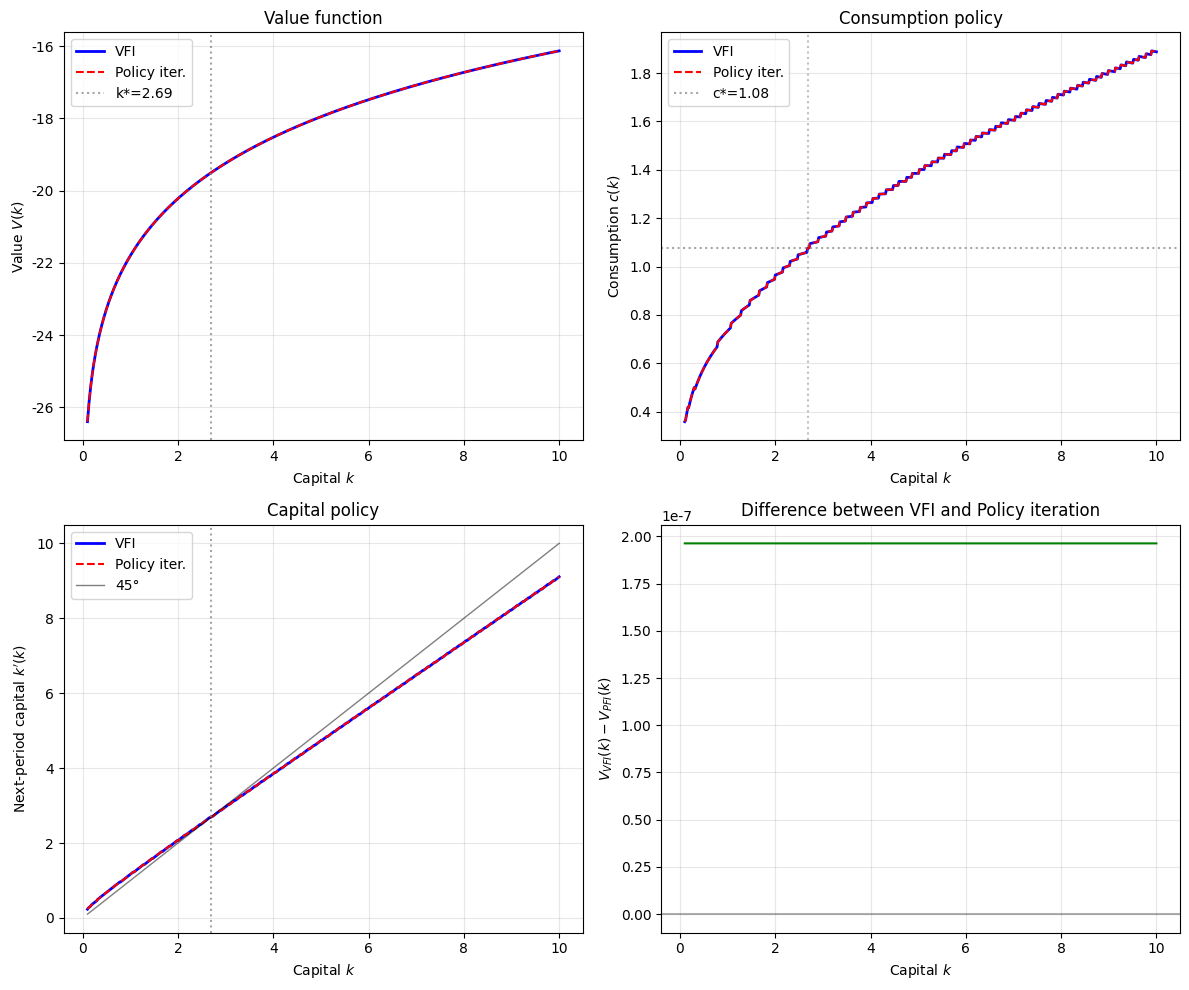

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Value function (VFI vs PFI)
axes[0, 0].plot(k_grid, V_vfi, 'b-', lw=2, label='VFI')
axes[0, 0].plot(k_grid, V_pfi, 'r--', lw=1.5, label='Policy iter.')
axes[0, 0].axvline(k_ss, color='gray', ls=':', alpha=0.7, label=f'k*={k_ss:.2f}')
axes[0, 0].set_xlabel('Capital $k$')
axes[0, 0].set_ylabel('Value $V(k)$')
axes[0, 0].set_title('Value function')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Consumption policy
axes[0, 1].plot(k_grid, c_vfi, 'b-', lw=2, label='VFI')
axes[0, 1].plot(k_grid, c_pfi, 'r--', lw=1.5, label='Policy iter.')
axes[0, 1].axhline(c_ss, color='gray', ls=':', alpha=0.7, label=f'c*={c_ss:.2f}')
axes[0, 1].axvline(k_ss, color='gray', ls=':', alpha=0.5)
axes[0, 1].set_xlabel('Capital $k$')
axes[0, 1].set_ylabel('Consumption $c(k)$')
axes[0, 1].set_title('Consumption policy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Next-period capital policy
axes[1, 0].plot(k_grid, k_next_vfi, 'b-', lw=2, label='VFI')
axes[1, 0].plot(k_grid, k_next_pfi, 'r--', lw=1.5, label='Policy iter.')
axes[1, 0].plot(k_grid, k_grid, 'k-', lw=1, alpha=0.5, label='45°')
axes[1, 0].axvline(k_ss, color='gray', ls=':', alpha=0.7)
axes[1, 0].set_xlabel('Capital $k$')
axes[1, 0].set_ylabel("Next-period capital $k'(k)$")
axes[1, 0].set_title('Capital policy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Difference between VFI and PFI (should be tiny)
axes[1, 1].plot(k_grid, V_vfi - V_pfi, 'g-', lw=1.5)
axes[1, 1].axhline(0, color='k', ls='-', alpha=0.3)
axes[1, 1].set_xlabel('Capital $k$')
axes[1, 1].set_ylabel('$V_{VFI}(k) - V_{PFI}(k)$')
axes[1, 1].set_title('Difference between VFI and Policy iteration')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

- **Value function iteration**: repeatedly apply the Bellman operator until $V$ converges.
- **Policy function iteration (Howard)**: alternate between (1) solving for $V$ given the current policy, and (2) updating the policy by one-step maximization. Usually converges in fewer outer iterations than VFI.
- Both methods yield the same solution (up to grid and tolerance). The steady state $k^*$ is where $k'(k^*) = k^*$.